# Twittern Airlines sentiment Analysis

The data is collected from https://www.kaggle.com/crowdflower/twitter-airline-sentimentording 
According to the original source "A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service")". 

Our job is to analyze the sentiment and predict the category of the sentiment as "positive","negative","neutral"

In [68]:
from __future__ import print_function
import sys
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

## Read the csv file

In [2]:
input_df= pd.read_csv("twitter-airline-sentiment/Tweets.csv")

Check first few rows of the table

In [201]:
input_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Analysing the data and get some insights

The shape of the table: rows=14640, columns=15. Each row corresponds to one twitter user.

In [202]:
input_df.shape, input_df.columns

((14640, 15),
 Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
        'negativereason', 'negativereason_confidence', 'airline',
        'airline_sentiment_gold', 'name', 'negativereason_gold',
        'retweet_count', 'text', 'tweet_coord', 'tweet_created',
        'tweet_location', 'user_timezone'],
       dtype='object'))

Total number of passengers grouped by airlines

In [203]:
input_df["airline"].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

There are 3 different category of sentiments -"positive","negative","neutral"

In [204]:
input_df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

 Checking if there any null entry. Most importantly we care if the "text" entry is blank. As foolows there is no empty "text" entry. Good for us :). We do not need to deal with missing entry problem.

In [205]:
input_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

No of "postive", "negative" and "neutral" sentiments per airline

In [206]:
sentiments_per_airline=pd.crosstab(input_df["airline_sentiment"],input_df["airline"])
sentiments_per_airline

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1960,955,1186,2263,2633,181
neutral,463,723,664,381,697,171
positive,336,544,570,269,492,152


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


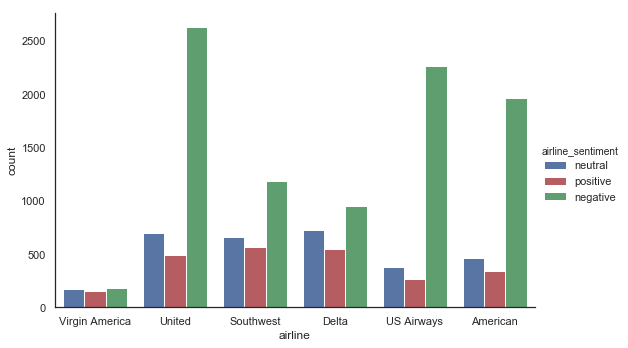

In [207]:
palette ={"positive":"C3","negative":"C2","neutral":"C0"}
with sns.axes_style('white'):
     sns.factorplot("airline",data=input_df, aspect=1.5,\
                       hue='airline_sentiment', kind='count',palette=palette)

We see from the table "sentiments_per_airline" is not a good way of measuring sentiment
rating as there are different no of passengers per airline. For example: Virgin America has
only 504 total passengers where United has 3822 passengers.

A better way to compare ratings is to compute the percent of positive, negative, and neutral ratings.

In [208]:
p=sentiments_per_airline.apply(lambda x: x/ x.sum() * 100.)
p

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,71.040232,42.979298,49.008264,77.686234,68.890633,35.912698
neutral,16.781443,32.538254,27.438017,13.079300,18.236525,33.928571
positive,12.178325,24.482448,23.553719,9.234466,12.872841,30.158730


Text(0,0.5,'percent of passengers')

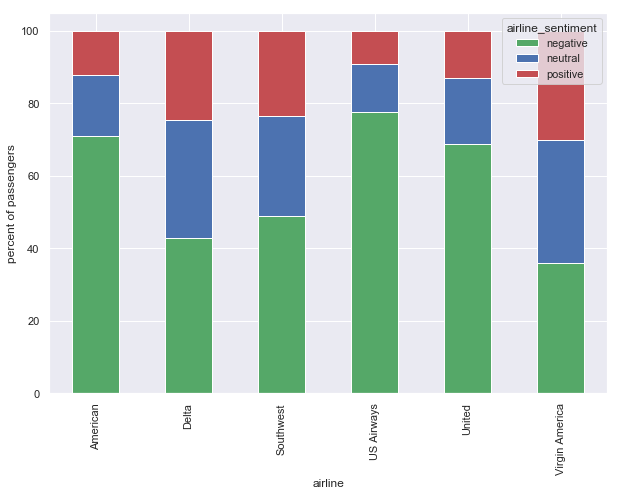

In [209]:
my_colors = 'gbred'
p.T.plot(kind='bar',figsize=(10, 7),stacked=True,color = my_colors)
plt.ylabel("percent of passengers")

Let's analyze the reason for giving negative rating. Looking at the following numbers 
and the plot we can infer that the "Customer Service Issue" and "Late Flight" play vital role.

In [210]:
input_df["negativereason"].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


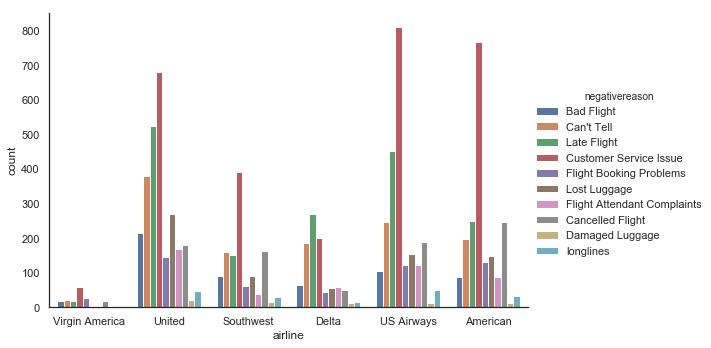

In [211]:
df=input_df.groupby(['airline','negativereason'])
df = df["airline_sentiment"].value_counts()
with sns.axes_style('white'):
     sns.factorplot("airline",data=input_df, aspect=1.5,\
                       hue='negativereason', kind='count')

In [212]:
input_df["negativereason"].isnull().sum()

5462

Around 40 % = (5462/14640)*100 of the "negativereason" rows are empty. Therefore we will use 
only "text" column for our model as X.

### Data Preprocessing

In [46]:
X = input_df['text']
y = input_df['airline_sentiment']

 Split data into train, test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape, y_train.shape

((7320,), (7320,))

We will use scikit-learn's feature extraction tool:
Term Frequency times Inverse Document Frequency (tf-idf)
For more details please see -https://en.wikipedia.org/wiki/Tf–idf

For improving performance of our model we shrink the vocabulary by removing stopwords from the "english" library which will remove some redunadant words "a", "the", "about"


In [61]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',normalize=True):
    cmap = plt.get_cmap('Reds')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white"
                     if cm[i, j] > thresh else "black")
        
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Support Vector Machine

Best parameters set: {'C': 1, 'kernel': 'linear'}
Grid scores on every set of parameters:

0.754 (+/-0.0075) for {'C': 1, 'kernel': 'linear'}
0.726 (+/-0.0032) for {'C': 10, 'kernel': 'linear'}
0.708 (+/-0.0228) for {'C': 100, 'kernel': 'linear'}
0.621 (+/-0.0003) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.621 (+/-0.0003) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.621 (+/-0.0003) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.672 (+/-0.0043) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.621 (+/-0.0003) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.621 (+/-0.0003) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.747 (+/-0.0040) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.673 (+/-0.0046) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.621 (+/-0.0003) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.716 (+/-0.0064) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.747 (+/-0.0048) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.673 (+/-0.0048) for {'C': 1000, '

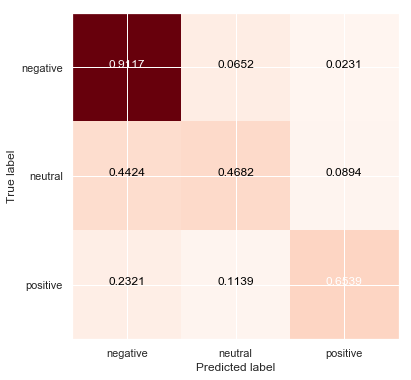

In [64]:
parameters = [{'kernel': ['linear'], 'C': [1, 10, 100]},\
              {'kernel': ['rbf'], 'gamma': [1e-2,1e-3, 1e-4],'C': [1, 10, 100, 1000]}]

tfidf=TfidfVectorizer(stop_words='english')
clf=GridSearchCV(SVC(),parameters,cv=2,refit=True)
model= make_pipeline(tfidf,clf)
model.fit(X_train, y_train)



print("Best parameters set:",clf.best_params_)
print("Grid scores on every set of parameters:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.04f) for %r"
              % (mean, std * 2, params))
    
    
print()
print("Classification report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Test accuracy:",accuracy_score(y_test, y_pred))
labels = model.classes_
matrix = confusion_matrix(y_test,y_pred)
print(pd.DataFrame(matrix,columns=labels, index=labels))
plot_confusion_matrix(matrix,labels)

We obtain 78 % accuracy using linear SVM.

## Random Forest Classifier

Best parameters set: {'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 300}
Grid scores on every set of parameters:

0.718 (+/-0.005) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 50}
0.722 (+/-0.006) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 250}
0.723 (+/-0.000) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 300}
0.723 (+/-0.002) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 50}
0.720 (+/-0.007) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 250}
0.721 (+/-0.003) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 300}
0.720 (+/-0.006) for {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'n_estimators': 50}
0.722 (+/-0.005) for {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'n_estimators': 250}
0.722 (+/-0.001) for {'criterion': 'gi

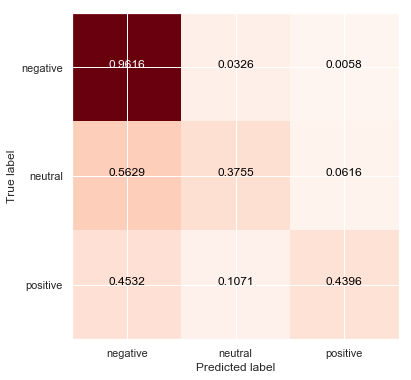

In [67]:
parameters = {"max_depth": [None],"max_features": [1,3,10],
              "criterion": ["gini", "entropy"],"n_estimators":[50,250,300]}
tfidf=TfidfVectorizer(stop_words='english')
clf=GridSearchCV(RandomForestClassifier(),param_grid=parameters,cv=2,refit=True)
model= make_pipeline(tfidf,clf)
model.fit(X_train, y_train)



print("Best parameters set:",clf.best_params_)
print("Grid scores on every set of parameters:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    
print()
print("Classification report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Test accuracy:",accuracy_score(y_test, y_pred))
labels = model.classes_
matrix = confusion_matrix(y_test,y_pred)
print(pd.DataFrame(matrix,columns=labels, index=labels))
plot_confusion_matrix(matrix,labels)